In [1]:

import os
os.chdir("/Data")
def convert_rating(rating):
    if rating >= 7:
        return 2
    elif 4 < rating < 7:
        return 1
    else:
        return 0

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader, random_split
import torch
torch.manual_seed(0)
class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.data = self.data[:].dropna()
        self.text = self.data['review'].tolist()
        self.target1 = self.data['drug'].tolist()
        self.target2 = self.data['condition'].tolist()
        self.rating = self.data['rating'].tolist()


        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        # Retrieve label encoders from the provided dictionary


        # Encode target variables using the retrieved label encoders


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.text[idx]
        target1 = self.target1[idx]
        target2 = self.target2[idx]
        rating = torch.tensor(convert_rating(self.rating[idx]))
        text = target1 +"[SEP]"+target2 +"[SEP]"+text
        # print(text)
        # Tokenize the text
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'rating':rating,
            'original_rating':self.rating[idx]
        }

# Example usage:
csv_file =r"./df_test_20_final.csv"

# Create label encoders for target variables

# Fit label encoders on target variables
data = pd.read_csv(csv_file)

# Create dataset with label encoders
dataset = CustomDataset(csv_file)

# Divide the dataset into training and validation sets


# Example usage of dataloaders for training and validation
test_dataloader = DataLoader(dataset, batch_size=2, shuffle=False)


# for i in train_dataloader:
#   print(i)

import torch
import torch.nn as nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, num_classes1, num_classes2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(r'bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, num_classes1)


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)

        # Use pooled_output for final classification
        logits1 = self.fc1(pooled_output)


        return logits1

# Example usage:

model = BertClassifier( 3,1)

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# Define loss function
criterion = nn.CrossEntropyLoss()

def calculate_metrics(preds, targets):
    # If preds is a 2D tensor with shape (batch_size, num_classes), then use argmax along dim=1
    if preds.dim() == 2:
        preds = preds.argmax(dim=1).cpu().numpy()
    # If preds is a 1D tensor with shape (batch_size,), then no need for argmax
    elif preds.dim() == 1:
        preds = preds.cpu().numpy()
    else:
        raise ValueError("Unsupported shape for preds tensor")

    targets = targets.cpu().numpy()
    accuracy = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='macro')
    return accuracy, f1


c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# import torch
# # Load the saved model state dictionary
model_path = r"./rating_bng_mymodel.pth"
model.load_state_dict(torch.load(model_path))
print("Model loaded successfully!")

In [2]:
from tqdm import tqdm
def convert_rating_inverse(encoded_rating):
    if encoded_rating == 0:
        return 'Bad'
    elif encoded_rating == 1:
        return 'Neutral'
    elif encoded_rating == 2:
        return 'Good'
    else:
        raise ValueError("Invalid encoded rating. Must be 0, 1, or 2.")

def inference(model, dataloader, device):
    model = model.to(device)
    model.eval()
    all_preds1 = []
    all_preds2 = []
    all_targets1 = []
    all_targets2 = []

    for batch in tqdm(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # target1 = batch['target1'].to(device)
        target2 = batch['rating'].to(device)

        logits2 = model(input_ids, attention_mask)

        # all_preds1.extend(logits1.argmax(dim=1).cpu().numpy())
        all_preds2.extend(logits2.argmax(dim=1).cpu().numpy())
        # all_targets1.extend(target1.cpu().numpy())
        all_targets2.extend(target2.cpu().numpy())

    # Reverse label encoding
    # label_encoder1 = label_encoders['target1']
    # label_encoder2 = label_encoders['target2']
    # original_preds1 = label_encoder1.inverse_transform(all_preds1)
    
    # original_targets1 = label_encoder1.inverse_transform(all_targets1)
    

    return  all_preds2, all_targets2


# Perform inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds2,  targets2 = inference(model, test_dataloader, device)

# Analysis of predictions
for  pred2,  target2 in zip( preds2, targets2):
    # print(f'Predicted target1: {pred1}, Original target1: {target1}')
    print(f'Predicted target2: {pred2}, Original target2: {target2}')
    print()  # Add a newline for readability


100%|██████████| 11558/11558 [12:24<00:00, 15.53it/s]

Predicted target2: 2, Original target2: 2

Predicted target2: 2, Original target2: 2

Predicted target2: 2, Original target2: 1

Predicted target2: 2, Original target2: 0

Predicted target2: 2, Original target2: 1

Predicted target2: 2, Original target2: 0

Predicted target2: 2, Original target2: 2

Predicted target2: 2, Original target2: 0

Predicted target2: 2, Original target2: 2

Predicted target2: 2, Original target2: 0

Predicted target2: 2, Original target2: 2

Predicted target2: 2, Original target2: 2

Predicted target2: 2, Original target2: 0

Predicted target2: 2, Original target2: 2

Predicted target2: 2, Original target2: 1

Predicted target2: 2, Original target2: 0

Predicted target2: 2, Original target2: 0

Predicted target2: 2, Original target2: 1

Predicted target2: 2, Original target2: 2

Predicted target2: 2, Original target2: 0

Predicted target2: 2, Original target2: 2

Predicted target2: 2, Original target2: 0

Predicted target2: 2, Original target2: 0

Predicted t

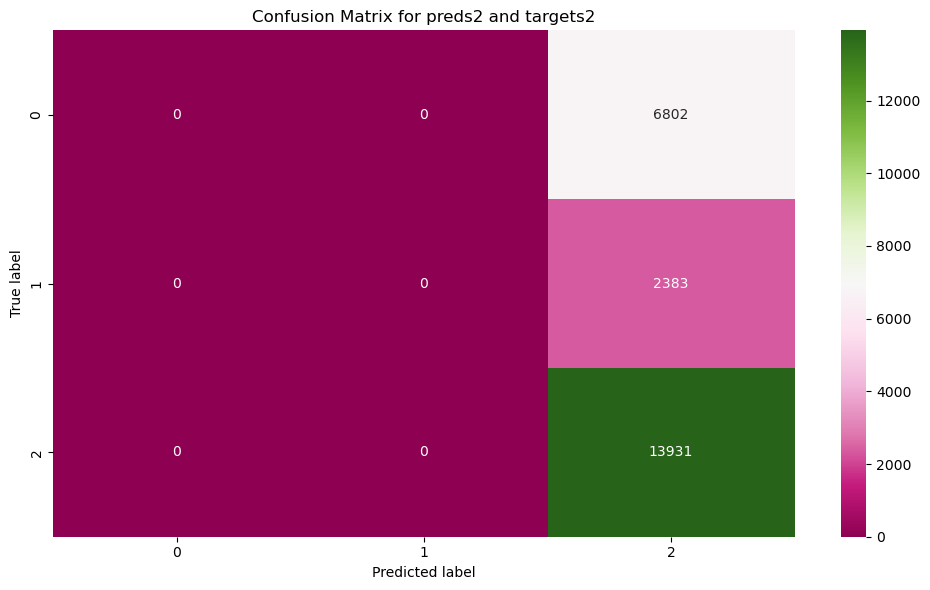

For preds2 and targets2:
Accuracy: 0.6026561688873507
F1 Score: 0.2506905642382199
Confusion Matrix:
 [[    0     0  6802]
 [    0     0  2383]
 [    0     0 13931]]
For preds2 and targets2:
Accuracy: 0.6026561688873507
F1 Score: 0.2506905642382199
Confusion Matrix:
 [[    0     0  6802]
 [    0     0  2383]
 [    0     0 13931]]


In [4]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Assuming preds2, preds2, targets2, and targets2 are your prediction and target arrays/lists

# Calculate accuracy

# Calculate accuracy
accuracy_1 = accuracy_score(targets2, preds2)
# accuracy_2 = accuracy_score(targets2, preds2)

# Calculate F1 score
f1_score_1 = f1_score(targets2, preds2,average="macro")


# Calculate confusion matrix
conf_matrix_1 = confusion_matrix(targets2, preds2)


plt.figure(figsize=(10, 6))

plt.subplot(1, 1, 1)
sns.heatmap(conf_matrix_1, annot=True,fmt='d', cmap='PiYG')
plt.title("Confusion Matrix for preds2 and targets2")
plt.xlabel("Predicted label")
plt.ylabel("True label")


plt.tight_layout()
plt.show()

print("For preds2 and targets2:")
print("Accuracy:", accuracy_1)
print("F1 Score:", f1_score_1)
print("Confusion Matrix:\n", conf_matrix_1)


print("For preds2 and targets2:")
print("Accuracy:", accuracy_1)
print("F1 Score:", f1_score_1)
print("Confusion Matrix:\n", conf_matrix_1)
